<a href="https://colab.research.google.com/github/RaminTKhameneh/ECG/blob/main/ECG_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F
from scipy.io import arff

In [29]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
with open('drive/MyDrive/695/ECG5000_TRAIN.txt', 'r') as file:
    test = file.read()
    test = test.split('\n')
    test = [row.split() for row in test]
with open('drive/MyDrive/695/ECG5000_TEST.txt', 'r') as file:
    train = file.read()
    train = train.split('\n')
    train = [row.split() for row in train]

In [35]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)
train.drop(index=train.index[-1],axis=0,inplace=True)
test.drop(index=test.index[-1],axis=0,inplace=True)

<ipython-input-36-a99bd16c1de4>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


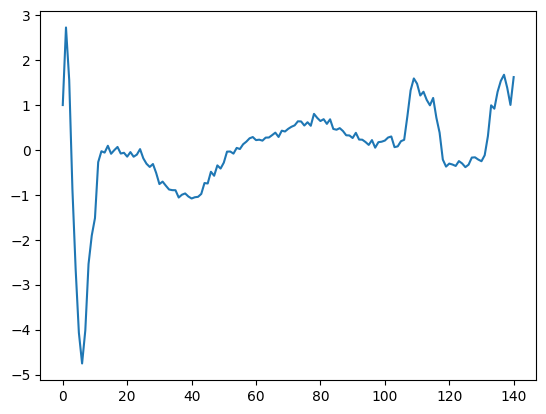

In [36]:
df = train.append(test)
# df = df.sample(frac=1.0)
# aa = [3.6908442,0.71141435,-2.1140915,-4.1410068,-4.5744716,-3.4319085,-1.9507914,-1.1070667,-0.63232248,0.33457718,0.87883579,0.83106672,0.83246584,0.79099271,0.73318448,0.67531414,0.76075122,0.64545074,0.64472425,0.59314006,0.60070077,0.4967947,0.40954629,0.33081901,0.15958058,0.20091363,0.10775284,-0.039164736,-0.096833474,-0.17062963,-0.2969516,-0.38126935,-0.36309706,-0.5013618,-0.67307625,-0.55188068,-0.65094102,-0.54260816,-0.66110174,-0.58118387,-0.45428738,-0.45106516,-0.29907368,-0.21448719,-0.076921402,0.10233773,0.20839504,0.15054113,0.21366603,0.24493933,0.30699451,0.33835116,0.34609696,0.41369076,0.44100555,0.39159341,0.41750854,0.30276646,0.38036357,0.28972908,0.37412731,0.39876561,0.36499806,0.63122707,0.50918961,0.46911811,0.61013159,0.59380291,0.56851494,0.6185489,0.75104048,0.49345872,0.53952164,0.64126341,0.60935203,0.59405769,0.40790413,0.42761301,0.43085571,0.41528731,0.31350561,0.35372391,0.26930733,0.16958593,0.2408928,0.13035327,0.18621097,0.024304193,-0.068152656,0.0095436502,-0.16012437,-0.135601,-0.15552812,-0.14475897,-0.00397988,-0.040228089,-0.051341236,0.038336424,0.34101747,0.6159584,0.81549648,0.91215047,1.197038,1.5258563,1.6774093,1.4938024,1.3328849,1.033417,0.70938029,0.50417612,0.12197655,-0.14469165,-0.70622151,-0.97195913,-1.092812,-1.2048382,-1.1141657,-1.0873249,-1.2853534,-1.2481586,-1.2101424,-1.2784696,-1.2789237,-1.3769847,-1.2328171,-1.189943,-1.3444164,-1.2390104,-1.1742654,-0.69966643,-0.032476949,0.022846766,0.18893657,0.48093188,0.62925026,0.57729083,0.66552725,1.0359968,1.4922866,-1.9050734,1]
df = df.astype(float)
aa = np.array(df.loc[1000])
aa.shape
plt.figure()
plt.plot(aa)

In [37]:
df = train.append(test)
# df = df.sample(frac=1.0)
df.shape

<ipython-input-37-d6494d8792a7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


(5000, 141)

In [38]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0000000e+00,3.6908442e+00,7.1141435e-01,-2.1140915e+00,-4.1410068e+00,-4.5744716e+00,-3.4319085e+00,-1.9507914e+00,-1.1070667e+00,-6.3232248e-01,...,-3.2476949e-02,2.2846766e-02,1.8893657e-01,4.8093188e-01,6.2925026e-01,5.7729083e-01,6.6552725e-01,1.0359968e+00,1.4922866e+00,-1.9050734e+00
1,1.0000000e+00,-1.3481323e+00,-3.9960376e+00,-4.2267496e+00,-4.2511874e+00,-3.4779528e+00,-2.2284217e+00,-1.8084877e+00,-1.5342415e+00,-7.7986138e-01,...,9.3798389e-01,1.5709378e+00,1.5913944e+00,1.5491932e+00,1.1930770e+00,5.1513440e-01,1.2627351e-01,2.6753217e-01,1.0711484e+00,-1.1640090e+00
2,1.0000000e+00,1.0242946e+00,-5.9031419e-01,-1.9169491e+00,-2.8069890e+00,-3.5279051e+00,-3.6386750e+00,-2.7797674e+00,-2.0190308e+00,-1.9807535e+00,...,3.6882000e-01,4.4350192e-01,8.2758242e-01,1.2370070e+00,1.2351214e+00,1.7381027e+00,1.8007674e+00,1.8163009e+00,1.4739633e+00,1.3897666e+00
3,1.0000000e+00,5.4565692e-01,-1.0143830e+00,-2.3166977e+00,-3.6340397e+00,-4.1968570e+00,-3.7580926e+00,-3.1944444e+00,-2.2217637e+00,-1.5885544e+00,...,8.9463842e-01,7.7752982e-01,1.1192396e+00,9.0298365e-01,5.5409760e-01,4.9705263e-01,4.1811561e-01,7.0310771e-01,1.0646019e+00,-4.4853163e-02
4,1.0000000e+00,6.6113283e-01,-1.5524706e+00,-3.1246406e+00,-4.3133515e+00,-4.0170422e+00,-3.0059934e+00,-1.8324110e+00,-1.5038856e+00,-1.0717055e+00,...,1.4165819e+00,1.2808227e+00,1.4943155e+00,1.6187644e+00,1.4474491e+00,1.2385768e+00,1.7496922e+00,1.9868029e+00,1.4227564e+00,-3.5778384e-01


In [39]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

df = df.reset_index()
del df['index']

In [44]:
new_columns = list(df.columns)
new_columns[0] = 'target'
df.columns = new_columns


df = df.astype({'target':'float'})

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']
class_names

['Normal', 'R on T', 'PVC', 'SP', 'UB']

In [47]:
df.target.value_counts()
# df.target

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: target, dtype: int64

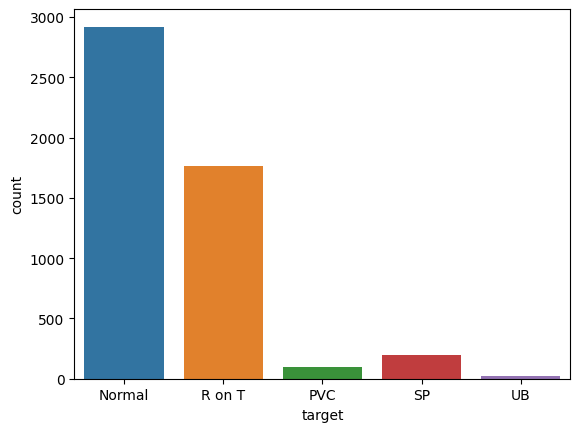

In [49]:
fig, ax = plt.subplots()
sns.countplot(x='target', data=df, ax=ax)

ax.set_xticklabels(['Normal', 'R on T', 'PVC', 'SP', 'UB'])

plt.show()

In [50]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
    )
    ax.set_title(class_name)

0 1.0
1 2.0
2 3.0
3 4.0
4 5.0


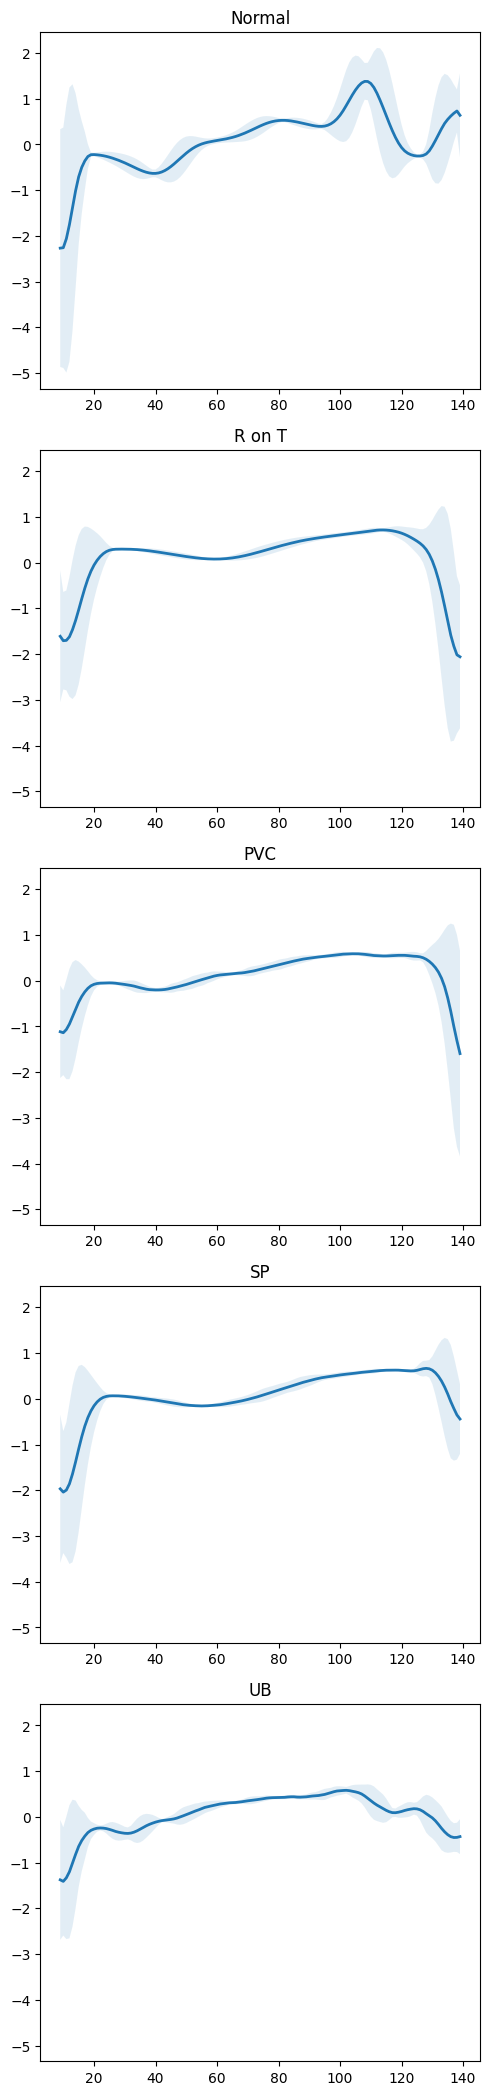

In [64]:
df = df.astype(float)

classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 1 + 1,
    ncols=1,
    sharey=True,
    figsize=(5, 25)
    )

for i, cls in enumerate(classes):
    print(i,cls)
    ax = axs.flat[i]
    data = df[df.target == cls].drop(labels='target', axis=1).mean().to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [53]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [54]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [55]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [56]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [57]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [58]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))


In [59]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [60]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [61]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 72.03450810664222 val loss 55.580340193400204
Epoch 2: train loss 55.254680527452976 val loss 53.58123759767708
Epoch 3: train loss 53.624106753501906 val loss 53.023821300207146
Epoch 4: train loss 52.00431320793155 val loss 51.94203133957378
Epoch 5: train loss 49.93912187443295 val loss 49.28170938459273
Epoch 6: train loss 46.550537657516706 val loss 45.10289569112628
Epoch 7: train loss 38.01330637287969 val loss 33.77313134125068
Epoch 8: train loss 34.42223132939552 val loss 31.818449450027412
Epoch 9: train loss 33.12553665917614 val loss 31.129814291163107
Epoch 10: train loss 30.89376135153042 val loss 27.524458523903284
Epoch 11: train loss 29.35736907772939 val loss 32.54190901277822
Epoch 12: train loss 29.293519771949555 val loss 24.22387981414795
Epoch 13: train loss 27.629240839964726 val loss 24.784551945969515
Epoch 14: train loss 26.325374554453816 val loss 24.208846128027595
Epoch 15: train loss 27.271595891086097 val loss 24.15819503992491
Epoch

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

<ipython-input-35-b1e9518eed74>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


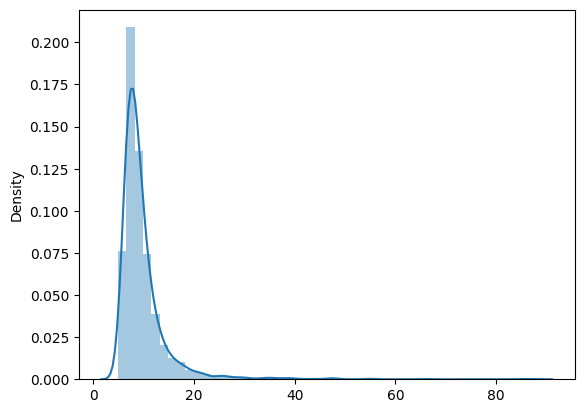

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 26

<ipython-input-37-ed53989f8e41>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


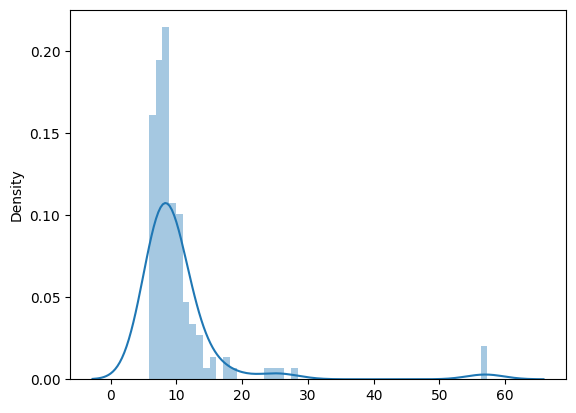

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 141/145


In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-40-ad94685d44b0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


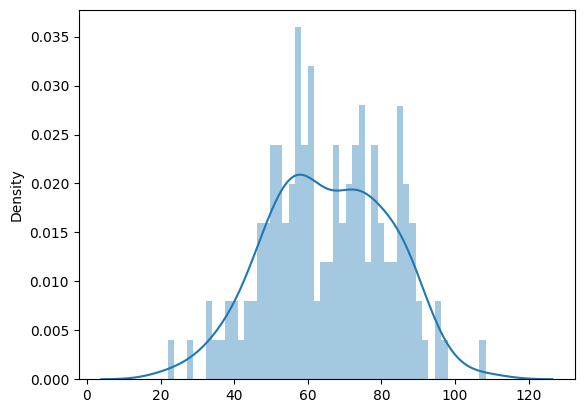

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 144/145


In [ ]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()


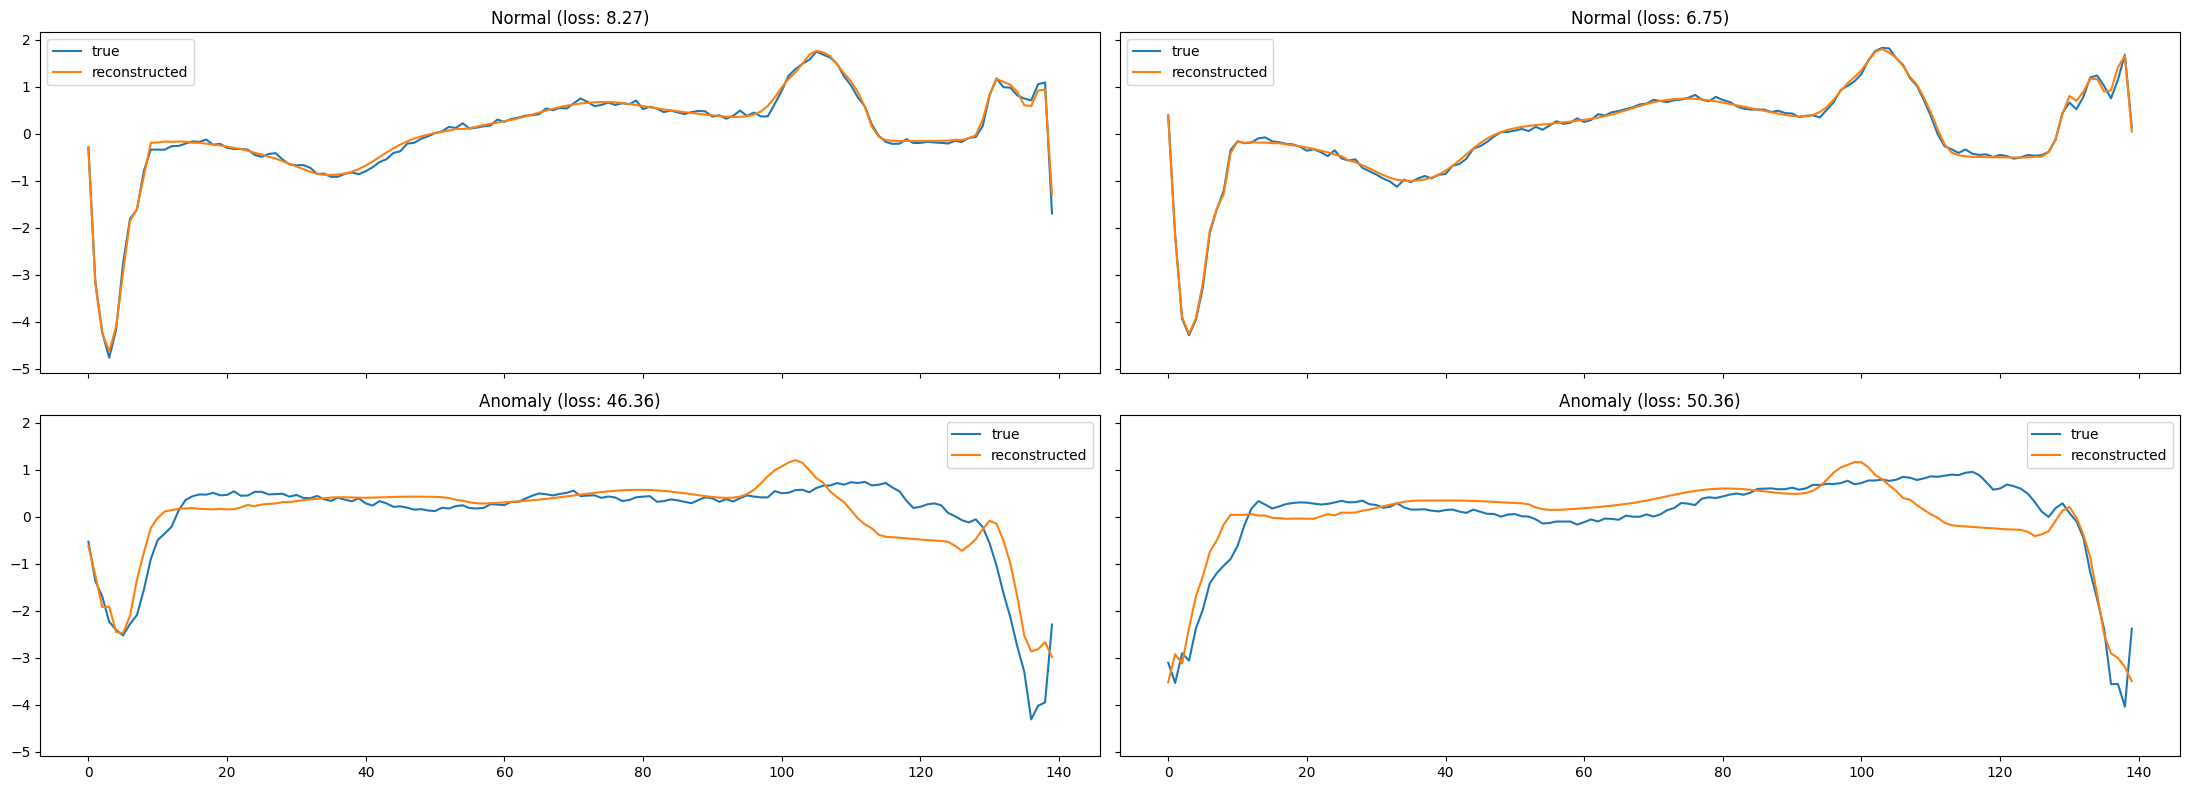

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=2,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:2]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:2]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();